In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('all-star-dataset.csv')
df = df.dropna(subset=['player'])
# df = df[df['season'] > 2010]

FileNotFoundError: [Errno 2] No such file or directory: 'all-star-dataset.csv'

EDA

In [15]:
print("Head of the dataset:")
print(df.head(), "\n")

print("Dataset info:")
print(df.info(), "\n")

print("Summary statistics:")
print(df.describe(), "\n")

df.fillna(df.select_dtypes(include=[np.number]).median(), inplace=True)

Head of the dataset:
   season           player  player_id   g    gs      mp   fg  fga   x3p  x3pa  \
0    2020         Naz Reid     4771.0  30  11.0   495.0  100  243  32.0  97.0   
3    2017    Zach Randolph     3362.0  73   5.0  1786.0  433  964  21.0  94.0   
4    2012  DeMarre Carroll     3873.0  24   9.0   348.0   43  105   7.0  19.0   
6    2018         Ed Davis     3932.0  78   0.0  1471.0  170  292   0.0   1.0   
7    2015    Tyler Johnson     4297.0  32   2.0   603.0   70  167  18.0  48.0   

   ...  fta    orb    drb  ast   stl   blk   tov   pf   pts  all_star  
0  ...   53   34.0   90.0   35  19.0  22.0  22.0   83   269     False  
3  ...  193  182.0  416.0  122  38.0  10.0  99.0  136  1028     False  
4  ...   16   28.0   25.0   18  12.0   1.0  11.0   37   107     False  
6  ...  111  183.0  392.0   40  32.0  52.0  66.0  188   414     False  
7  ...   47   14.0   67.0   42  33.0   9.0  30.0   42   190     False  

[5 rows x 23 columns] 

Dataset info:
<class 'pandas.core.f

Explore Features

In [16]:
# Points per minute (handle division by zero)
df['ppm'] = np.where(df['mp'] > 0, df['pts'] / df['mp'], 0)

# Shooting percentages (avoid division by zero)
df['fg_pct']   = np.where(df['fga'] > 0, df['fg'] / df['fga'], 0)
df['x3p_pct']  = np.where(df['x3pa'] > 0, df['x3p'] / df['x3pa'], 0)
df['x2p_pct']  = np.where(df['x2pa'] > 0, df['x2p'] / df['x2pa'], 0)
df['ft_pct']   = np.where(df['fta'] > 0, df['ft'] / df['fta'], 0)

# Assist-to-turnover ratio (if turnovers is 0, assign 0)
df['ast_tov'] = np.where(df['tov'] > 0, df['ast'] / df['tov'], 0)

# Total rebounds as a new feature
df['reb'] = df['orb'] + df['drb']

# Minutes per game
df['mpg'] = np.where(df['g'] > 0, df['mp'] / df['g'], 0)

Feature Selection

In [17]:
features_all_star = df.drop(columns=['player', 'season', 'all_star'])
X_all_star = features_all_star.select_dtypes(include=[np.number])
y_all_star = df['all_star']

# Use a Random Forest classifier to rank feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_all_star, y_all_star)
importances = clf.feature_importances_
feat_importances = pd.Series(importances, index=X_all_star.columns)
feat_importances = feat_importances.sort_values(ascending=False)
print("Feature importances for predicting All-Star status:")
print(feat_importances, "\n")

Feature importances for predicting All-Star status:
mpg          0.149760
pts          0.127373
fta          0.106651
ft           0.097218
fga          0.056390
fg           0.048648
ppm          0.047307
x2pa         0.042911
tov          0.039940
x2p          0.037601
player_id    0.024044
reb          0.023605
gs           0.018330
drb          0.018046
ast          0.017955
g            0.014126
pf           0.013780
fg_pct       0.012207
ft_pct       0.011865
stl          0.011479
blk          0.011374
x2p_pct      0.011088
x3pa         0.010717
mp           0.010440
orb          0.009700
x3p          0.009544
ast_tov      0.009126
x3p_pct      0.008778
dtype: float64 



Model Selection & Training

In [18]:
# Use selected features to predict 'mpg' (minutes played per game)
features = df[['pts', 'ft', 'fta', 'fg', 'fga', 'ppm', 'x2pa', 'tov', 'x2p', 'reb', 'drb', 'ast']]
target = df['mpg']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----- Linear Regression -----
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# ----- Decision Tree Regressor -----
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

# ----- Random Forest Regressor -----
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

Model Evaluation

In [19]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, R^2: {r2:.2f}")

print("Model Evaluation on Test Data:")
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)
print("\n")

Model Evaluation on Test Data:
Linear Regression - RMSE: 4.46, R^2: 0.81
Decision Tree - RMSE: 5.07, R^2: 0.76
Random Forest - RMSE: 3.65, R^2: 0.87




Analysis

In [20]:
# Use the best performing model (e.g., Random Forest) to predict ideal minutes for all players.
df['predicted_mpg'] = rf.predict(scaler.transform(features))
df['difference'] = df['predicted_mpg'] - df['mpg']

# Identify overutilized players (actual minutes significantly higher than predicted)
overutilized = df.sort_values(by='difference').head(10)
# Identify underutilized players (actual minutes significantly lower than predicted)
underutilized = df.sort_values(by='difference', ascending=False).head(10)

print("Top 10 Overutilized Players (predicted ideal < actual):")
print(overutilized[['player', 'mpg', 'predicted_mpg', 'difference']], "\n")
print("Top 10 Underutilized Players (predicted ideal > actual):")
print(underutilized[['player', 'mpg', 'predicted_mpg', 'difference']], "\n")

Top 10 Overutilized Players (predicted ideal < actual):
                 player        mpg  predicted_mpg  difference
3569       Jaylen Hoard  34.285714      10.715085  -23.570629
2486      Ryan Anderson  36.136364      17.618261  -18.518103
2624   Patrick Beverley  30.363636      13.986000  -16.377636
964   Mitchell Robinson  27.516129      15.031960  -12.484169
4757          Luol Deng  39.425926      28.603860  -10.822066
2548      Kenyon Martin  23.944444      13.134347  -10.810098
3053     Melvin Frazier  40.000000      29.476417  -10.523583
2539      Fred VanVleet  36.519231      28.253448   -8.265783
516         Vander Blue  37.000000      28.865946   -8.134054
646     Tosan Evbuomwan  21.588235      13.495497   -8.092738 

Top 10 Underutilized Players (predicted ideal > actual):
                 player        mpg  predicted_mpg  difference
3793  Marreese Speights  15.881579      26.482613   10.601034
2046      Grayson Allen  10.947368      19.291445    8.344076
196    Andrew Gou

Visualizing Results

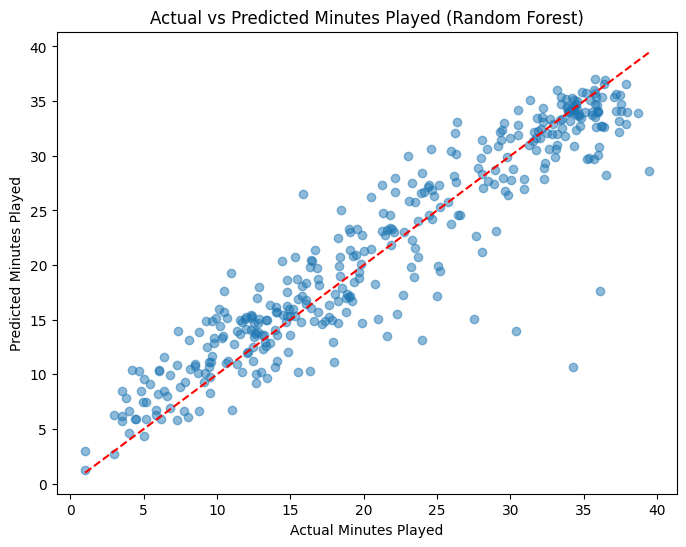

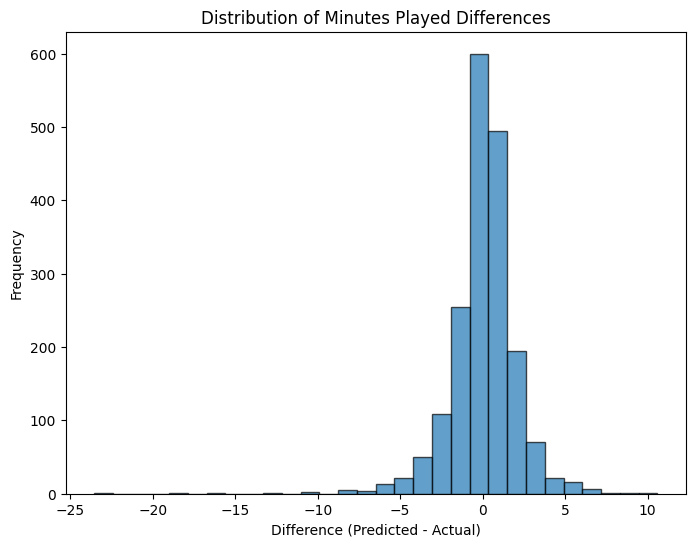

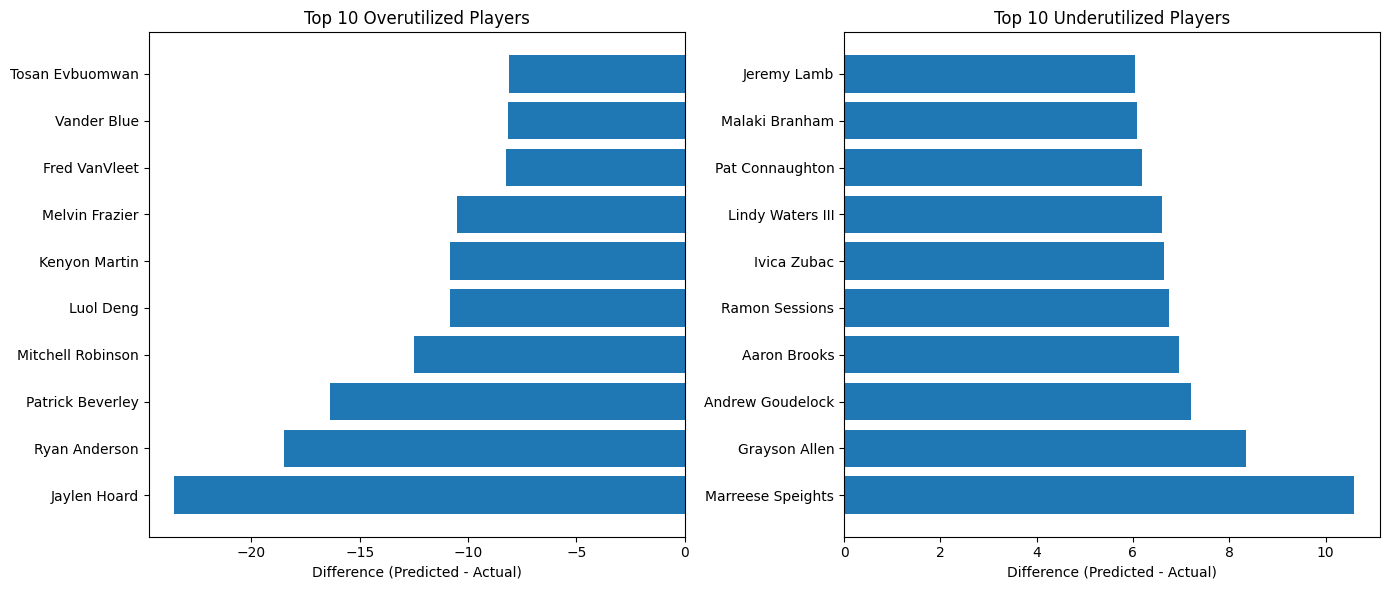

In [21]:
# Scatter plot: Actual vs Predicted Minutes (Random Forest)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Minutes Played")
plt.ylabel("Predicted Minutes Played")
plt.title("Actual vs Predicted Minutes Played (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Histogram of differences
plt.figure(figsize=(8,6))
plt.hist(df['difference'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Difference (Predicted - Actual)")
plt.ylabel("Frequency")
plt.title("Distribution of Minutes Played Differences")
plt.show()

# Bar charts for top overutilized and underutilized players
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].barh(overutilized['player'], overutilized['difference'])
ax[0].set_title("Top 10 Overutilized Players")
ax[0].set_xlabel("Difference (Predicted - Actual)")
ax[1].barh(underutilized['player'], underutilized['difference'])
ax[1].set_title("Top 10 Underutilized Players")
ax[1].set_xlabel("Difference (Predicted - Actual)")
plt.tight_layout()
plt.show()


In [3]:
plt.figure(figsize=(10,6))
plt.scatter(df['difference'], df['pts'], alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Ideal Usage')
plt.xlabel("Predicted MPG - Actual MPG")
plt.ylabel("Points per Game")
plt.title("Utilization Difference vs Scoring Output")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>